# Cross-species annotation
### PreProcessing (see on merge_data.ipynb)
0) Select and download relevant datasets
1) Condense similar annotation info into same obs columns
2) Map gene variables to homologus gene variables
3) QC + Basic Filtering
6) Subset each dataset.var by only shared genes by at least 2 species
7) Merge datasets (outer merge to conserve obs-metadata, fill_value=0)

### Processing (this notebook)

8) Scale & PCA
9) Spearman correlation of PC to QC metrics & drop technical PC
9) Harmony integration
10) Neighbors / clustering on integrated representation
11) Compute overlap metrics (per-cluster entropy & species fractions)
12) Cross-validation evaluation (hide 20% human+mouse, majority-vote, cofusion matrix)

In [2]:
import os
import glob
import scanpy as sc
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import harmonypy as hm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

from scipy.stats import entropy
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from collections import Counter

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)

In [4]:
rev_n = 12
region = 'cerebral_cortex'

In [5]:
filename = f'/home/ratopin/big_data/combined/{region}_combined_outer_adata{rev_n}.h5ad'

## Pre-processing
- Start with raw_merged data
- Filter
- Normalize
- Log transform
- Find HVG
- Combat (batch correction)

In [6]:
adata = sc.read(filename)
print(f"Succesfully loaded {filename}. Shape: {adata.shape}")

Succesfully loaded /home/ratopin/big_data/combined/cerebral_cortex_combined_outer_adata12.h5ad. Shape: (31043, 19066)


In [7]:
adata

AnnData object with n_obs × n_vars = 31043 × 19066
    obs: 'species', 'sample_id', 'region', 'donor_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts', 'qc_composite', 'qc_label', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'dataset_source', 'stage', 'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Age', 'CellClass', 'Region', 'Subregion', 'cell_cycle_score', 'total_genes', 'dataset'
    var: 'mt-human_adult', 'ribo-human_adult', 'n_cells_by_counts-human_adult', 'mean_counts-human_adult', 'log1p_mean_counts-human_adult', 'pct_dr

In [8]:
print(adata.shape)
print(adata.obs.columns)
print(adata.obs['dataset'].value_counts())

(31043, 19066)
Index(['species', 'sample_id', 'region', 'donor_id', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb',
       'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts',
       'qc_composite', 'qc_label', 'suspension_type', 'dissection',
       'total_UMIs', 'cluster_id', 'roi', 'dataset_source', 'stage',
       'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Age',
       'CellClass', 'Region', 'Subregion', 'cell_cycle_score', 'total_genes',
       'dataset'],
      dtype='object')
dataset
nmr            24378
human_adult     4665
human_dev       2000
Name: 

### QC metrics

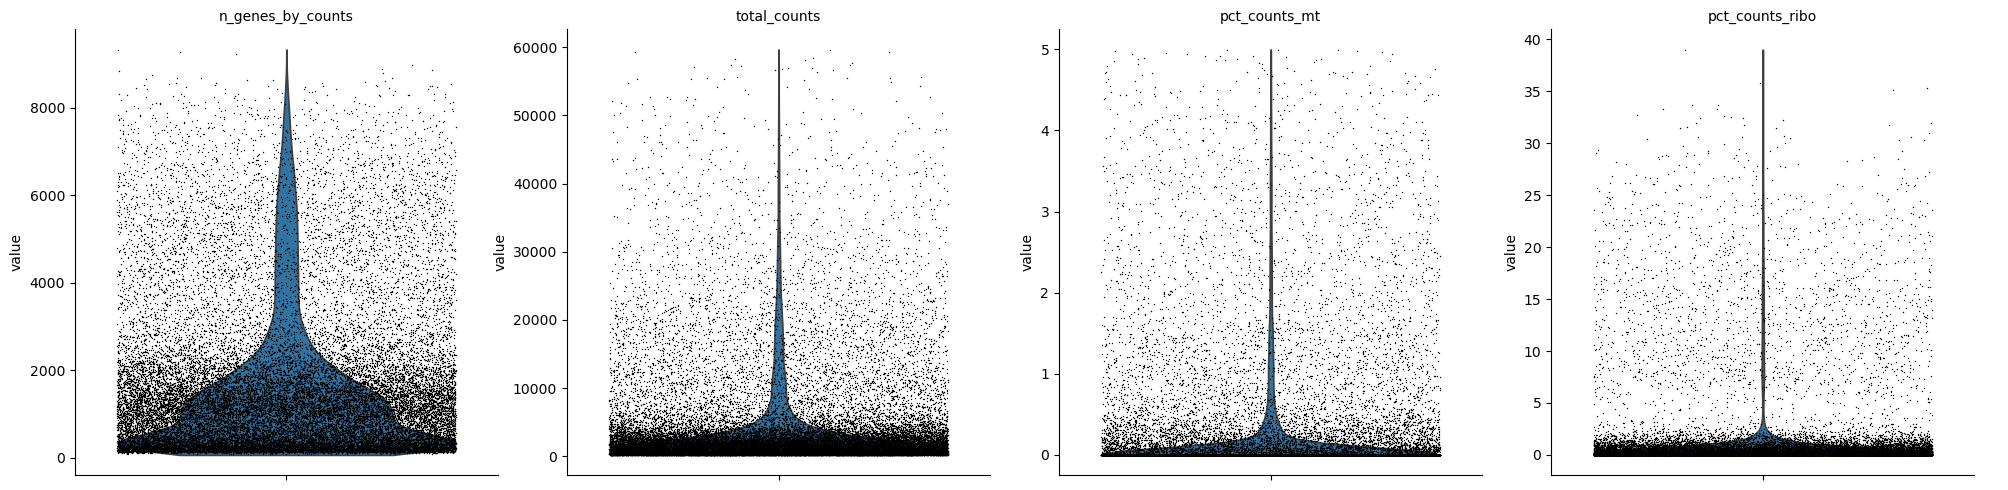

In [9]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt", 'pct_counts_ribo'],
    jitter=0.4,
    multi_panel=True
)

### HVG

In [10]:
sc.pp.normalize_total(adata, exclude_highly_expressed=True, max_fraction=0.05)

In [11]:
sc.pp.log1p(adata)

In [12]:
sc.pp.highly_variable_genes(adata, n_top_genes = 5000, subset=False)

In [13]:
adata.var

mt-human_adult  ribo-human_adult  n_cells_by_counts-human_adult  \
global_name                                                                    
A1BG                  False             False                            NaN   
A1CF                  False             False                           32.0   
A2M                   False             False                          468.0   
A3GALT2               False             False                           77.0   
A4GALT                False             False                           25.0   
...                     ...               ...                            ...   
ZYG11A                False             False                            NaN   
ZYG11B                False             False                            NaN   
ZYX                   False             False                         1795.0   
ZZEF1                 False             False                         2526.0   
ZZZ3                  False             False                         3440.0   

             mean_counts-human_adult  log1p_mean_counts-human_adult  \
global_name                                                           
A1BG                             NaN                            NaN   
A1CF                        0.008046                       0.008014   
A2M                         0.171240                       0.158063   
A3GALT2                     0.016505                       0.016370   
A4GALT                      0.006396                       0.006375   
...                              ...                            ...   
ZYG11A                           NaN                            NaN   
ZYG11B                           NaN                            NaN   
ZYX                         0.649268                       0.500331   
ZZEF1                       1.061894                       0.723625   
ZZZ3                        2.021457                       1.105739   

             pct_dropout_by_counts-human_adult  total_counts-human_adult  \
global_name                                                                
A1BG                                       NaN                       NaN   
A1CF                                 99.339798                      39.0   
A2M                                  90.344543                     830.0   
A3GALT2                              98.411388                      80.0   
A4GALT                               99.484217                      31.0   
...                                        ...                       ...   
ZYG11A                                     NaN                       NaN   
ZYG11B                                     NaN                       NaN   
ZYX                                  62.966784                    3147.0   
ZZEF1                                47.885290                    5147.0   
ZZZ3                                 29.028265                    9798.0   

             log1p_total_counts-human_adult  n_cells-human_adult  \
global_name                                                        
A1BG                                    NaN                  NaN   
A1CF                               3.688879                 30.0   
A2M                                6.722630                456.0   
A3GALT2                            4.394449                 75.0   
A4GALT                             3.465736                 24.0   
...                                     ...                  ...   
ZYG11A                                  NaN                  NaN   
ZYG11B                                  NaN                  NaN   
ZYX                                8.054523               1739.0   
ZZEF1                              8.546364               2466.0   
ZZZ3                               9.190036               3377.0   

            global_name-human_adult  ... pct_dropout_by_counts-nmr  \
global_name                          ...                             
A1BG                            Na

I have seen that normalization prior to harmony affects overlap, therefore we will subset the genes by the top highly variable, but avoiding to modify the adata.X

### Scale and PCA

In [14]:
sc.pp.scale(adata)
sc.pp.pca(adata, svd_solver='arpack', use_highly_variable=True)

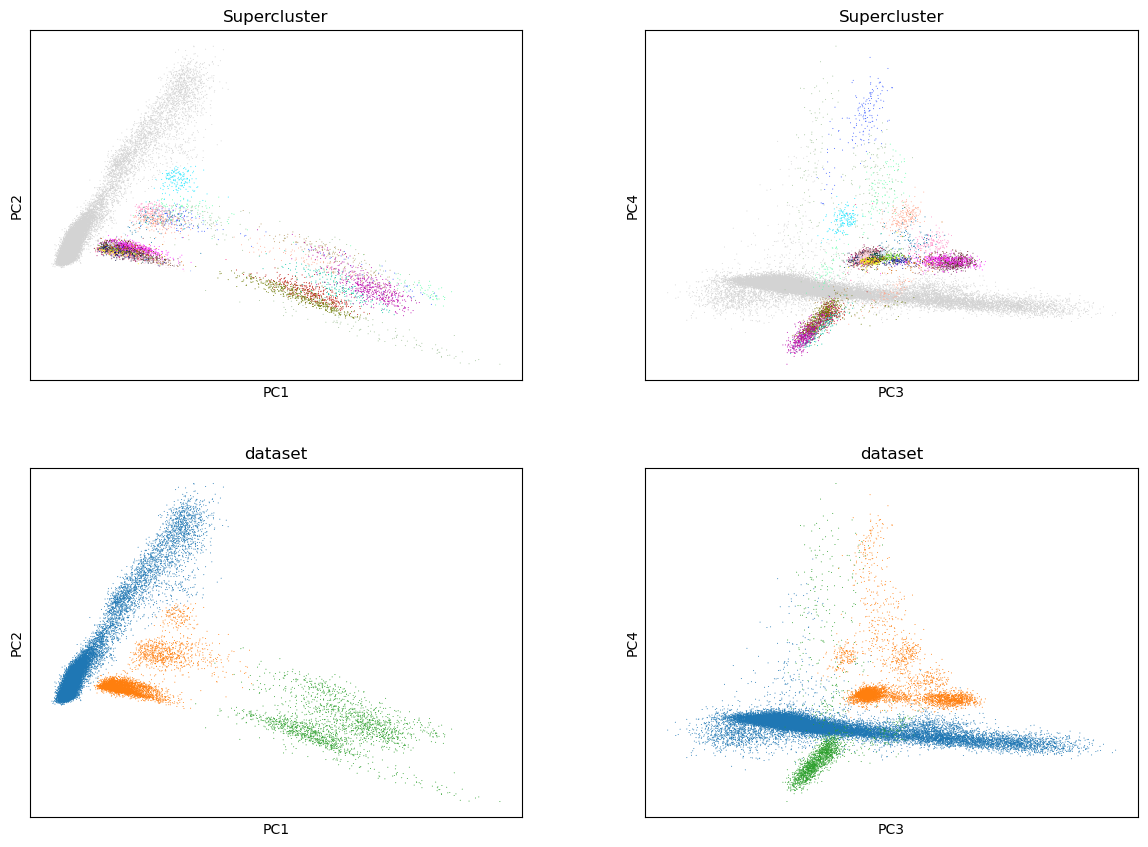

In [15]:
sc.pl.pca(
    adata,
    color=["Supercluster","Supercluster", "dataset", "dataset"],
    dimensions=[(0,1),(2,3), (0,1),(2,3)],
    ncols=2,
    size=2,
    save=f'_by_supertype{rev_n}.png',
    legend_loc='none' 
)

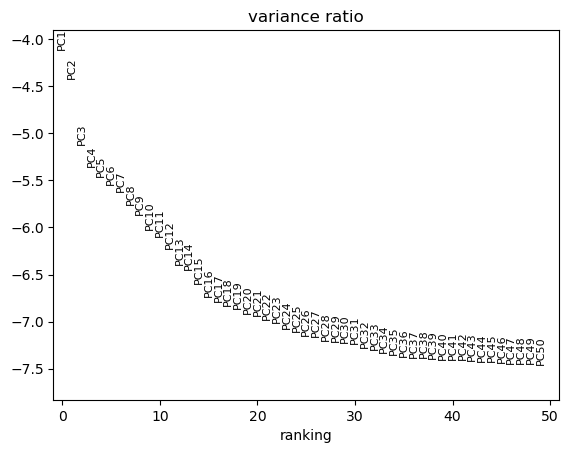

In [16]:
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True, save=f'{rev_n}.png')

In [17]:
import sys

module_dir = os.path.abspath('/home/ratopin/NMR-snRNA-seq/scanpy/')
sys.path.append(module_dir)
from special_functions import check_pc_correlation, plot_pc_qc_correlation

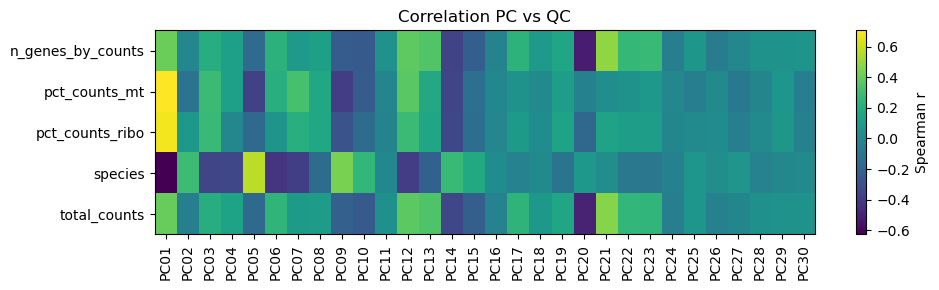

In [18]:
origPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(origPCcorr, save_path=f'pc_qc_correlation_before_harmony{rev_n}.png')

In [19]:
# PC2 and PC4 looks problematic so I rather delete it
adata_copy = adata.copy() # save backup
#adata.obsm["X_pca"] = np.delete(adata.obsm["X_pca"], [1,3], axis=1) 

In [20]:
adata.obsm["X_pca"] = np.delete(adata.obsm["X_pca"], 4, axis=1) 

In [ ]:
#return to this checkpoint
adata = adata_copy.copy()

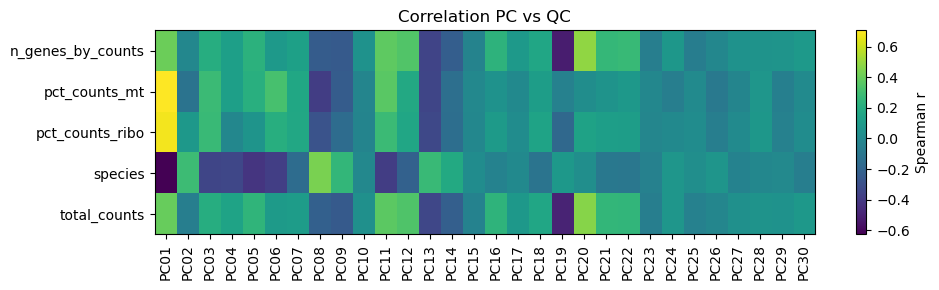

In [21]:
secondPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca")
plot_pc_qc_correlation(secondPCcorr, save_path=f'pc_qc_correlation_pc2_dropped{rev_n}.png')
# just a little improvement

### Harmony Integration

For species integration, we can adjust some parameters so that batch correction is more agressive

> **Diversity Penalty** `theta`: default 2, use 3 or 4 to force clusters to have a more balanced composition of species
>
> **Ridge Regression Penalty** `lambda`: default 1, use 0.5 to allow Harmony to make larger corrections to the PCA embeddings
>
> **Early Stop** `early_stop`: default True, set to False
>
> **`max_iter`**: default 10, this umber is ok but it can be modified.

In [22]:
pca_mat = adata.obsm['X_pca']

harmony_out = hm.run_harmony(pca_mat, adata.obs, 'dataset',
                             max_iter_harmony = 15,
                             theta = 3,
                             lamb = 0.5, # Allow more aggressive correction
                             )

adata.obsm['X_pca_harmony'] = harmony_out.Z_corr  # check harmonypy return shape; adapt accordingly
# many wrappers exist; alternatively use sc.external.pp.harmony_integrate if available


2026-02-05 21:30:07,586 - harmonypy - INFO - Running Harmony (PyTorch on cpu)
2026-02-05 21:30:07,587 - harmonypy - INFO -   Parameters:
2026-02-05 21:30:07,588 - harmonypy - INFO -     max_iter_harmony: 15
2026-02-05 21:30:07,589 - harmonypy - INFO -     max_iter_kmeans: 20
2026-02-05 21:30:07,589 - harmonypy - INFO -     epsilon_cluster: 1e-05
2026-02-05 21:30:07,590 - harmonypy - INFO -     epsilon_harmony: 0.0001
2026-02-05 21:30:07,590 - harmonypy - INFO -     nclust: 100
2026-02-05 21:30:07,591 - harmonypy - INFO -     block_size: 0.05
2026-02-05 21:30:07,592 - harmonypy - INFO -     lamb: [0.5 0.5 0.5]
2026-02-05 21:30:07,593 - harmonypy - INFO -     theta: [3. 3. 3.]
2026-02-05 21:30:07,594 - harmonypy - INFO -     sigma: [0.1 0.1 0.1 0.1 0.1]...
2026-02-05 21:30:07,595 - harmonypy - INFO -     verbose: True
2026-02-05 21:30:07,595 - harmonypy - INFO -     random_state: 0
2026-02-05 21:30:07,596 - harmonypy - INFO -   Data: 49 PCs × 31043 cells
2026-02-05 21:30:07,597 - harmony

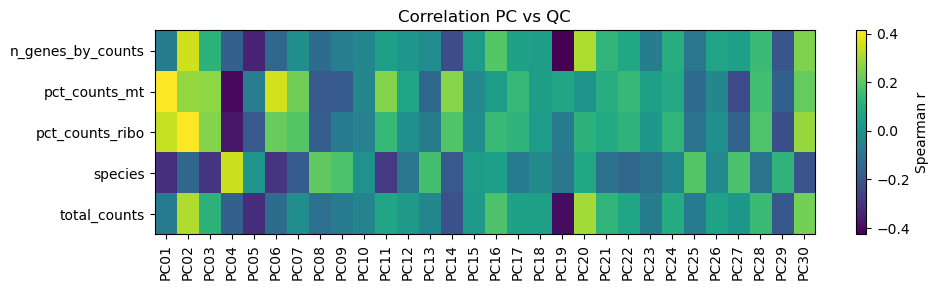

In [23]:
harmonyPCcorr = check_pc_correlation(adata, n_pcs=30, pc_col_name="X_pca_harmony")
plot_pc_qc_correlation(harmonyPCcorr, save_path=f'pc_qc_correlation_after_harmony{rev_n}.png')

In [ ]:
# sc.pp.combat(adata_hvg, key='dataset_name', inplace=True)
# combat is another type of batch correction, but harmonypy is generally better

### Normalize

In [24]:
# Normalizing to median total counts
sc.pp.normalize_total(adata)

### Neighbors
**Small n_neighbors** (e.g. 5–10): 

- Highlights fine-grained local relationships.

- Good for detecting rare cell populations. But can fragment larger, continuous populations into many tiny clusters.

**Large n_neighbors** (e.g. 30–50):

- Incorporates more global structure.

- Produces more coarse and global clusters.

- Good for datasets with strong batch effects (less sensitive to noise). But can miss rare cell types because they get merged into neighbors’ majority.


In [25]:
#Using rule of thumb  for n_neigbors used on neighors
import math
n_cells = adata.shape[0]
n_neighb = int(math.log10(n_cells) * 10)
print(f"Recommended n_neighbors ~ {n_neighb}")

Recommended n_neighbors ~ 44


In [26]:
len(adata.obsm['X_pca_harmony'][0])

49

In [28]:
rep = 'X_pca_harmony'  # use this integrated representation for clustering
sc.pp.neighbors(adata, use_rep=rep, n_neighbors=n_neighb)


/home/ratopin/miniconda3/envs/scanpy-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Clustering

In [29]:
sc.tl.leiden(adata, resolution=1, key_added='leiden_1.0')


In [31]:
sc.tl.leiden(adata, resolution=2.5, key_added='leiden_2.5')


### UMAP

In [33]:
sc.tl.umap(adata, min_dist=0.5) 

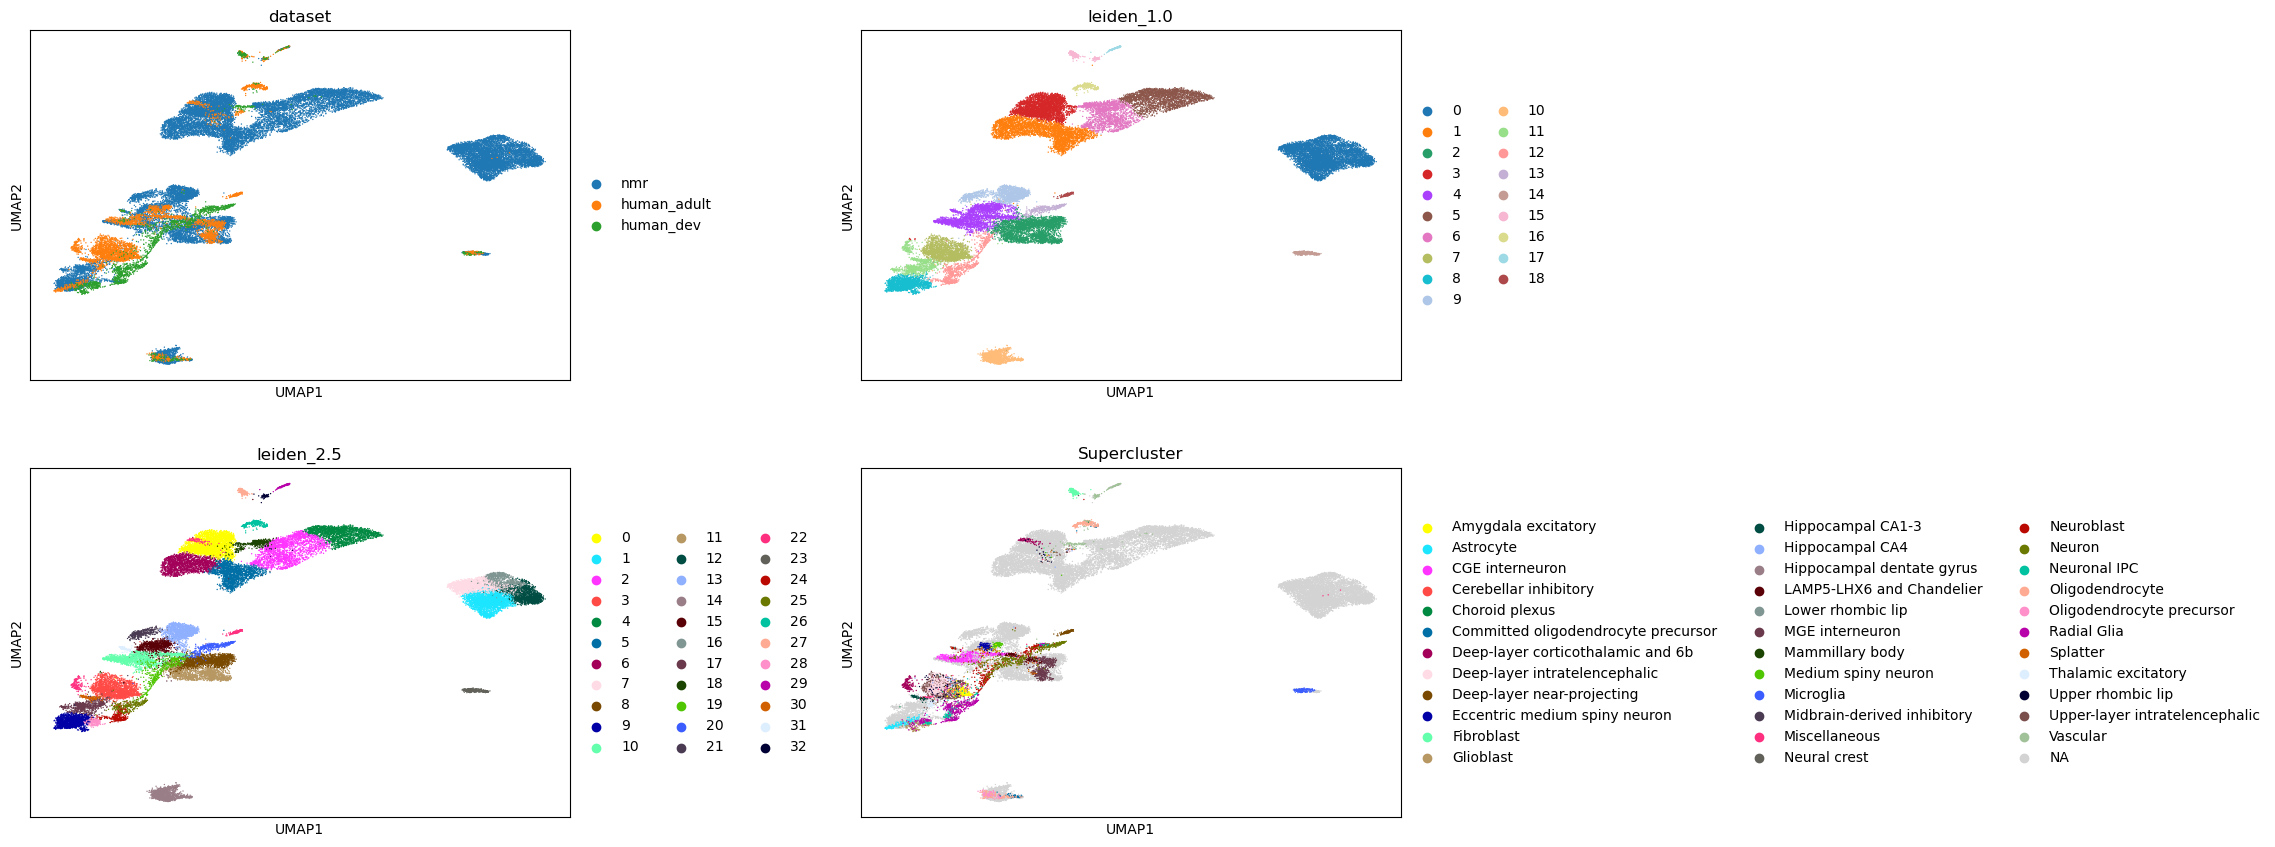

In [34]:
sc.pl.umap(adata, color=['dataset', 'leiden_1.0', 'leiden_2.5', 'Supercluster'], wspace=0.4, save=f"_{region}_clusters_harmony{rev_n}.png", ncols= 2)

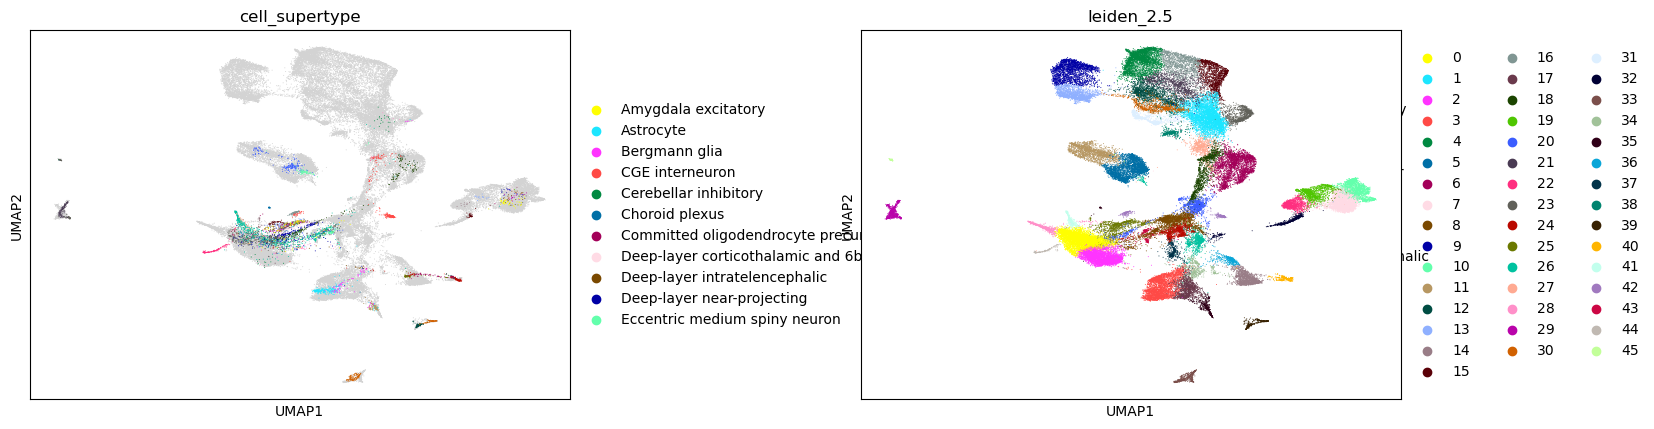

In [ ]:
sc.pl.umap(adata, color=['cell_supertype', 'leiden_2.5'], wspace=0.4, save=f"_{region}_clusters_harmony_types{rev_n}.png")

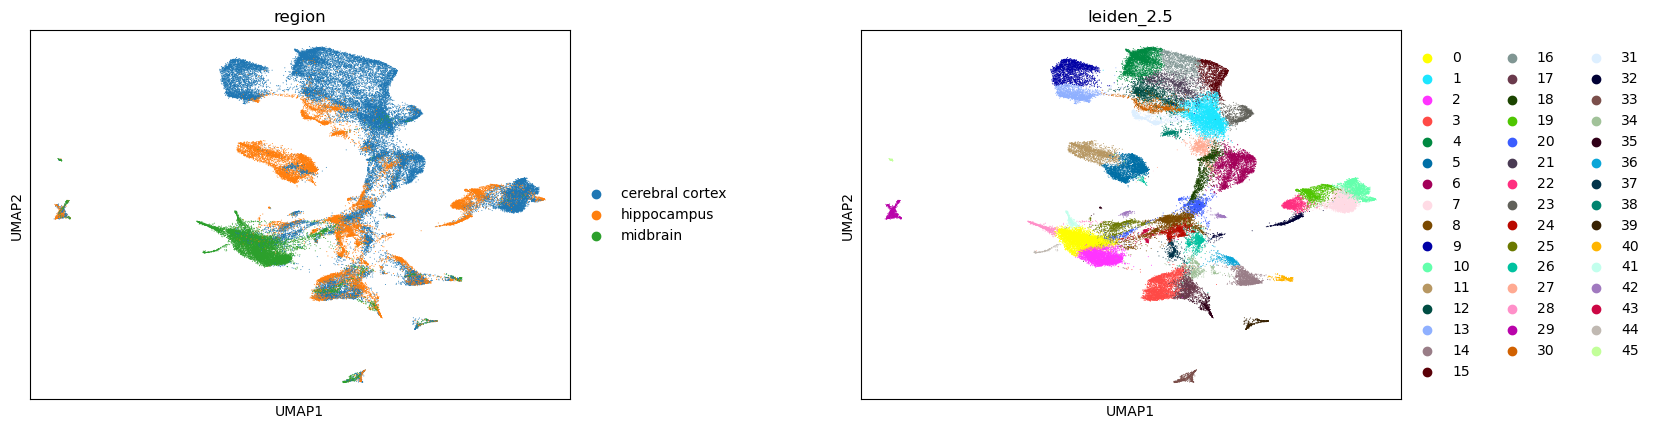

In [ ]:
sc.pl.umap(adata, color=['region', 'leiden_2.5'], wspace=0.4, save=f"_clusters_harmony_region{rev_n}.png")

In [36]:
## CHECKPOINT
out_filename = f'/home/ratopin/big_data/combined/integrated_{region}_clusters{rev_n}.h5ad'
adata.write_h5ad(out_filename)
print(f"AnnData object successfully saved to {out_filename}")

AnnData object successfully saved to /home/ratopin/big_data/combined/integrated_cerebral_cortex_clusters12.h5ad


#### Don't re-run previous code ;)
(too slow)

In [ ]:
try: adata = adata.copy()
except: adata = sc.read(f'/home/ratopin/big_data/combined/integrated_{region}_clusters{rev_n}.h5ad')

## Metrics calculation

In [37]:
def shannon_entropy_from_counts(counts, base=2):
    """Shannon entropy from a list/array of counts."""
    counts = np.array(counts, dtype=float)
    if counts.sum() == 0:
        return 0.0
    p = counts / counts.sum()
    p = p[p > 0]
    return entropy(p, base=base)


In [38]:
def icc_1way_single_measure(groups, values):
    """
    One-way random effects ICC(1,1).
    groups: array of group labels
    values: array of numeric values
    """
    groups = np.array(groups)
    values = np.array(values, dtype=float)
    unique_g = np.unique(groups)

    N = len(values)
    k = len(unique_g)
    n_i = np.array([np.sum(groups == g) for g in unique_g])

    mean_all = np.mean(values)
    mean_i = np.array([np.mean(values[groups == g]) for g in unique_g])

    ss_between = np.sum(n_i * (mean_i - mean_all) ** 2)
    ms_between = ss_between / (k - 1)

    ss_within = sum(
        np.sum((values[groups == g] - values[groups == g].mean()) ** 2)
        for g in unique_g
    )
    ms_within = ss_within / (N - k) if N > k else 0.0

    denom = ms_between + (n_i.mean() - 1) * ms_within
    icc = (ms_between - ms_within) / denom if denom > 0 else 0.0
    return icc


In [39]:
def compute_cluster_metrics(adata,
                            species_col='species',
                            cluster_col='cluster',
                            ann_col='annotation',
                            species_list=('human', 'mouse', 'nmr')):
    """
    Returns a pandas DataFrame with metrics per cluster.
    """
    obs = adata.obs.copy()
    # ensure cluster col is string-like
    obs['_cluster_str'] = obs[cluster_col].astype(str)
    clusters = obs['_cluster_str'].unique()
    rows = []
    for cl in sorted(clusters, key=lambda x: (float(x) if x.replace('.','',1).isdigit() else x)):
        sub = obs[obs['_cluster_str'] == cl]
        n_cells = len(sub)
        # pct not annotated (cells where ann_col is NA / empty)
        not_ann = sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == '')
        pct_not_annotated = not_ann.sum() / max(1, n_cells)
        # species mix entropy
        species_counts = sub[species_col].value_counts()
        # make sure we compute entropy over species_list order if provided
        species_counts_list = [species_counts.get(s, 0) for s in species_list]
        ent_species = shannon_entropy_from_counts(species_counts_list, base=2)
        # ICC: here we compute ICC of "species label as numeric group" on a dummy numeric vector (1s),
        # but that's meaningless. A better practical ICC for per-cluster species homogeneity:
        # compute ICC of a binary indicator per species across annotated identities:
        # instead compute ICC of species fraction across per-cell one-hot for species groups.
        # Implementation: for this cluster, create groups = species, values = 1 for each cell,
        # then ICC is computed across species groups — this effectively measures between-group variance.
        # (This is a proxy; you can replace with another continuous metric if preferred.)
        groups = sub[species_col].values
        values = np.ones(len(sub))
        icc_sp = icc_1way_single_measure(groups, values)
        # For human and mouse majority annotation within cluster:
        info = {'cluster': cl, 'n_cells': n_cells,
                'pct_not_annotated': pct_not_annotated,
                'shannon_entropy_species': ent_species,
                'icc_species_fraction': icc_sp}
        for sp in ['human', 'mouse']:
            sub_sp = sub[sub[species_col] == sp]
            if len(sub_sp) == 0:
                info[f'{sp}_majority_annotation'] = np.nan
                info[f'{sp}_majority_frac'] = np.nan
            else:
                # among these, consider only annotated cells
                ann_counts = sub_sp[~(sub_sp[ann_col].isna() | (sub_sp[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
                if ann_counts.sum() == 0:
                    info[f'{sp}_majority_annotation'] = np.nan
                    info[f'{sp}_majority_frac'] = 0.0
                else:
                    maj_ann = ann_counts.idxmax()
                    maj_frac = ann_counts.loc[maj_ann] / ann_counts.sum()
                    info[f'{sp}_majority_annotation'] = maj_ann
                    info[f'{sp}_majority_frac'] = float(maj_frac)
        # global majority among annotated cells in cluster
        ann_counts_global = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts_global.sum() == 0:
            info['global_majority_annotation'] = np.nan
            info['global_majority_frac'] = 0.0
        else:
            gmaj = ann_counts_global.idxmax()
            info['global_majority_annotation'] = gmaj
            info['global_majority_frac'] = float(ann_counts_global.loc[gmaj] / ann_counts_global.sum())
        rows.append(info)
    cluster_metrics = pd.DataFrame(rows).set_index('cluster')
    return cluster_metrics


In [40]:
def assign_cluster_majority(adata, cluster_metrics, ann_col='annotation', cluster_col='cluster'):
    """Add predicted annotation to adata.obs as 'predicted_annotation' based on cluster global majority."""
    obs = adata.obs
    # map cluster -> global_majority_annotation
    mapping = cluster_metrics['global_majority_annotation'].to_dict()
    obs['predicted_annotation'] = obs[cluster_col].astype(str).map(mapping).astype(object)
    # leave as NaN where mapping missing
    return None  # adata modified in place

In [41]:
# Pipeline for cross-species cluster-based annotation + metrics

def cross_validate_cluster_majority(adata,
                                    ann_col='annotation',
                                    species_col='species',
                                    cluster_col='cluster',
                                    species_to_mask=('human', 'mouse'),
                                    test_fraction=0.2,
                                    random_state=0):
    """
    For each species in species_to_mask:
      - stratify by annotation (if enough cells) and select test_fraction to hide
    Then: compute cluster majority using remaining labels and predict on held-out labels.
    Returns accuracy, confusion matrix and the indices of test cells.
    """
    obs = adata.obs.copy()
    # get indices for candidates (human+mouse annotated)
    candidates = obs[obs[species_col].isin(species_to_mask)].copy()
    # ensure annotated
    candidates = candidates[~(candidates[ann_col].isna() | (candidates[ann_col].astype(str).str.strip() == ''))]
    if candidates.empty:
        raise ValueError("No annotated human/mouse cells found for cross-validation.")
    test_idx = []
    train_mask = pd.Series(True, index=obs.index)
    # stratify within each species separately
    for sp in species_to_mask:
        sp_idx = candidates[candidates[species_col] == sp].index
        if len(sp_idx) == 0:
            continue
        y = candidates.loc[sp_idx, ann_col].values
        # if number of unique classes small or counts small, train_test_split stratify might fail.
        try:
            train_i, test_i = train_test_split(sp_idx, test_size=test_fraction, stratify=y, random_state=random_state)
        except Exception:
            # fallback: random sample
            test_i = np.random.RandomState(random_state).choice(sp_idx, size=max(1, int(len(sp_idx)*test_fraction)), replace=False)
            train_i = [i for i in sp_idx if i not in test_i]
        test_idx.extend(list(test_i))
        # mark those as hidden for training
        train_mask.loc[test_i] = False
    # create a copy of annotations for training where we mask test_idx
    obs_train = obs.copy()
    obs_train.loc[test_idx, ann_col] = np.nan
    # compute cluster majority from obs_train
    # build cluster -> majority annotation across all annotated cells in cluster (human+mouse+other if present)
    cluster_majority = {}
    for cl, sub in obs_train.groupby(cluster_col):
        ann_counts = sub[~(sub[ann_col].isna() | (sub[ann_col].astype(str).str.strip() == ''))][ann_col].value_counts()
        if ann_counts.sum() == 0:
            cluster_majority[cl] = np.nan
        else:
            cluster_majority[cl] = ann_counts.idxmax()
    # predictions for test cells
    y_true = obs.loc[test_idx, ann_col].values
    y_pred = [cluster_majority.get(cl, np.nan) for cl in obs.loc[test_idx, cluster_col].astype(str).values]
    # compute accuracy (ignore nan predictions if they occur)
    mask_valid = pd.Series(y_pred).notna().values
    if mask_valid.sum() == 0:
        acc = np.nan
    else:
        acc = accuracy_score(np.array(y_true)[mask_valid], np.array(y_pred)[mask_valid])
    # confusion matrix across classes that appear in true set (will include only predicted ones for which mapping exists)
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, pd.Series(y_pred), labels=labels)
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)
    return {'accuracy': float(acc) if not np.isnan(acc) else np.nan,
            'confusion_matrix': cm_df,
            'n_test': len(test_idx),
            'test_idx': test_idx,
            'cluster_majority_from_train': cluster_majority}



In [48]:
# create results folder if not exists
if not os.path.exists('results'):
    os.makedirs('results', exist_ok=True)

In [49]:
leiden_res = 'leiden_2.5'
cluster_metrics = compute_cluster_metrics(adata, species_col='species', cluster_col=leiden_res, ann_col='Supercluster')
print(cluster_metrics.head())
assign_cluster_majority(adata, cluster_metrics, ann_col='Supercluster', cluster_col=leiden_res)
cv_results = cross_validate_cluster_majority(adata, ann_col='Supercluster', cluster_col=leiden_res, species_col='species')
print("CV accuracy:", cv_results['accuracy'])
print("Confusion matrix:\n", cv_results['confusion_matrix'])
cluster_metrics.to_csv(f'./results/{region}_harmony_cluster_metrics{rev_n}.csv')

         n_cells  pct_not_annotated  shannon_entropy_species  \
cluster                                                        
0           2698           0.987398                 0.097587   
1           2381           0.999160                 0.009794   
2           2028           0.998521                 0.016039   
3           1739           0.027602                 0.182220   
4           1708           0.997073                 0.028855   

         icc_species_fraction       human_majority_annotation  \
cluster                                                         
0                         0.0               Upper rhombic lip   
1                         0.0                   Miscellaneous   
2                         0.0                        Vascular   
3                         0.0  Upper-layer intratelencephalic   
4                         0.0                        Vascular   

         human_majority_frac  mouse_majority_annotation  mouse_majority_frac  \
cluster        

In [50]:
adata.obs

species sample_id           region  donor_id  \
AAACCCAAGAAGCGAA-1-NMR1       nmr      NMR1  cerebral cortex  ratopin1   
AAACCCAAGGAGGCAG-1-NMR1       nmr      NMR1  cerebral cortex  ratopin1   
AAACCCACAAATCAAG-1-NMR1       nmr      NMR1  cerebral cortex  ratopin1   
AAACCCACAGTCTACA-1-NMR1       nmr      NMR1  cerebral cortex  ratopin1   
AAACCCAGTACGTAGG-1-NMR1       nmr      NMR1  cerebral cortex  ratopin1   
...                           ...       ...              ...       ...   
10X257_2:TCATACTCAGCACAGA   human  10X257_2  cerebral cortex   XDD:385   
10X257_2:TCCCATGTCGATTCCC   human  10X257_2  cerebral cortex   XDD:385   
10X257_4:ATTCCATCAGTGGTGA   human  10X257_4  cerebral cortex   XDD:385   
10X257_5:ATGCCTCAGGTCATTC   human  10X257_5  cerebral cortex   XDD:385   
10X257_6:GATCATGAGACCATGG   human  10X257_6  cerebral cortex   XDD:385   

                           n_genes_by_counts  log1p_n_genes_by_counts  \
AAACCCAAGAAGCGAA-1-NMR1                 1559                 7.352441   
AAACCCAAGGAGGCAG-1-NMR1                 1312                 7.180070   
AAACCCACAAATCAAG-1-NMR1                  491                 6.198479   
AAACCCACAGTCTACA-1-NMR1                 1841                 7.518607   
AAACCCAGTACGTAGG-1-NMR1                  478                 6.171701   
...                                      ...                      ...   
10X257_2:TCATACTCAGCACAGA               4065                 8.310415   
10X257_2:TCCCATGTCGATTCCC               4657                 8.446341   
10X257_4:ATTCCATCAGTGGTGA               3422                 8.138273   
10X257_5:ATGCCTCAGGTCATTC               5606                 8.631771   
10X257_6:GATCATGAGACCATGG               7034                 8.858653   

                           total_counts  log1p_total_counts  \
AAACCCAAGAAGCGAA-1-NMR1          2298.0            7.740230   
AAACCCAAGGAGGCAG-1-NMR1          1777.0            7.483244   
AAACCCACAAATCAAG-1-NMR1           679.0            6.522093   
AAACCCACAGTCTACA-1-NMR1          3369.0            8.122668   
AAACCCAGTACGTAGG-1-NMR1           710.0            6.566672   
...                                 ...                 ...   
10X257_2:TCATACTCAGCACAGA       10290.0            9.239025   
10X257_2:TCCCATGTCGATTCCC       14512.0            9.582800   
10X257_4:ATTCCATCAGTGGTGA        7718.0            8.951440   
10X257_5:ATGCCTCAGGTCATTC       20033.0            9.905186   
10X257_6:GATCATGAGACCATGG       31324.0           10.352172   

                           pct_counts_in_top_50_genes  \
AAACCCAAGAAGCGAA-1-NMR1                     14.882507   
AAACCCAAGGAGGCAG-1-NMR1                     14.350028   
AAACCCACAAATCAAG-1-NMR1                     29.602356   
AAACCCACAGTCTACA-1-NMR1                     19.709112   
AAACCCAGTACGTAGG-1-NMR1                     32.535211   
...                                               ...   
10X257_2:TCATACTCAGCACAGA                   15.617104   
10X257_2:TCCCATGTCGATTCCC                   18.598401   
10X257_4:ATTCCATCAGTGGTGA                   15.107541   
10X257_5:ATGCCTCAGGTCATTC                   13.757300   
10X257_6:GATCATGAGACCATGG                   13.762610   

                           pct_counts_in_top_100_genes  ...   Age  CellClass  \
AAACCCAAGAAGCGAA-1-NMR1                      22.062663  ...   NaN        NaN   
AAACCCAAGGAGGCAG-1-NMR1                      21.890827  ...   NaN        NaN   
AAACCCACAAATCAAG-1-NMR1                      42.415317  ...   NaN        NaN   
AAACCCACAGTCTACA-1-NMR1                      27.634313  ...   NaN        NaN   
AAACCCAGTACGTAGG-1-NMR1                      46.760563  ...   NaN        NaN   
...                                                ...  ...   ...        ...   
10X257_2:TCATACTCAGCACAGA                    21.632653  ...  14.0   Vascular   
10X257_2:TCCCATGTCGATTCCC                    26.033627  ...  14.0   Vascular   
10X257_4:ATTCCATCAGTGGTGA                    22.285566  ...  14.0   Vascular   
10X257_5:ATGCCTCAG

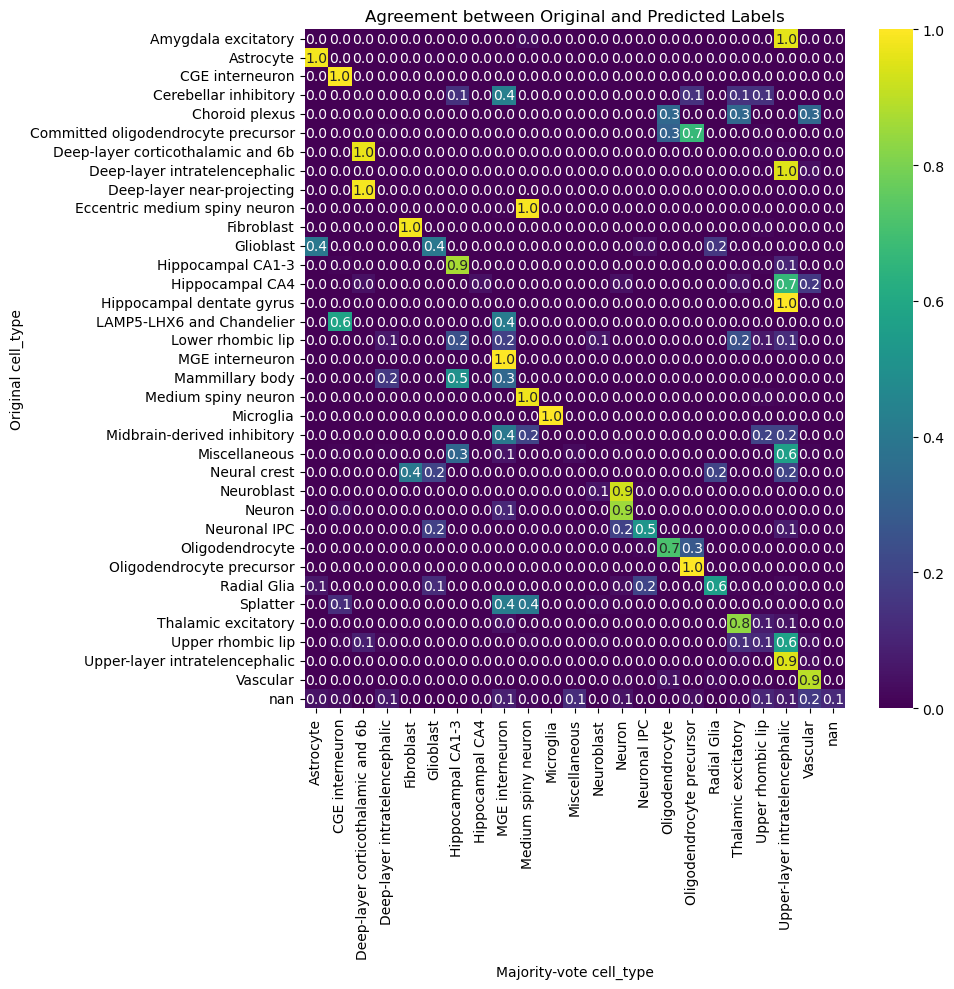

In [52]:
# Build confusion matrix
true_labels = adata.obs["Supercluster"].astype(str)
pred_labels = adata.obs["predicted_annotation"].astype(str)

cm = pd.crosstab(true_labels, pred_labels, rownames=["Original"], colnames=["Majority-vote"])

# Normalize rows (fractions per original label, easier to read)
cm_norm = cm.div(cm.sum(axis=1), axis=0)

# Plot heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(cm_norm, annot=True, fmt=".1f", cmap="viridis")
plt.title("Agreement between Original and Predicted Labels")
plt.ylabel("Original cell_type")
plt.xlabel("Majority-vote cell_type")
plt.tight_layout()
plt.show()

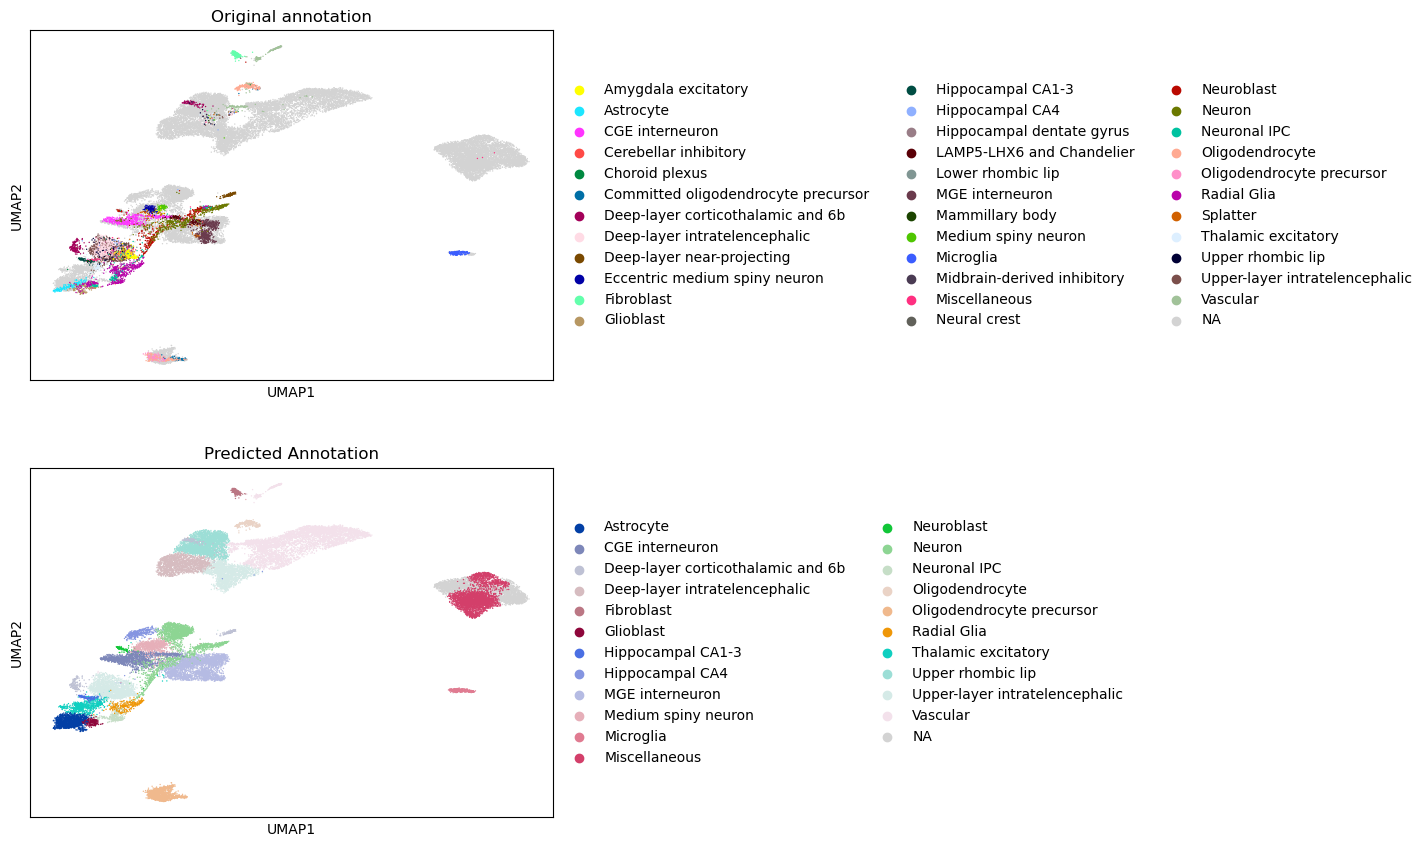

In [55]:
# Plot side by side
sc.pl.umap(
    adata,
    color=["Supercluster","predicted_annotation"],
    title=["Original annotation", 'Predicted Annotation'],
    ncols=1
)

In [56]:
adata.obs.columns

Index(['species', 'sample_id', 'region', 'donor_id', 'n_genes_by_counts',
       'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts',
       'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes',
       'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes',
       'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt',
       'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo',
       'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb',
       'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts',
       'qc_composite', 'qc_label', 'suspension_type', 'dissection',
       'total_UMIs', 'cluster_id', 'roi', 'dataset_source', 'stage',
       'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Age',
       'CellClass', 'Region', 'Subregion', 'cell_cycle_score', 'total_genes',
       'dataset', 'leiden_1.0', 'leiden_2.5', 'predicted_annotation'],
      dtype='object')

In [57]:
adata.obs['dataset'][adata.obs['region'].notna()]

AAACCCAAGAAGCGAA-1-NMR1            nmr
AAACCCAAGGAGGCAG-1-NMR1            nmr
AAACCCACAAATCAAG-1-NMR1            nmr
AAACCCACAGTCTACA-1-NMR1            nmr
AAACCCAGTACGTAGG-1-NMR1            nmr
                               ...    
10X257_2:TCATACTCAGCACAGA    human_dev
10X257_2:TCCCATGTCGATTCCC    human_dev
10X257_4:ATTCCATCAGTGGTGA    human_dev
10X257_5:ATGCCTCAGGTCATTC    human_dev
10X257_6:GATCATGAGACCATGG    human_dev
Name: dataset, Length: 31043, dtype: category
Categories (3, object): ['nmr', 'human_adult', 'human_dev']

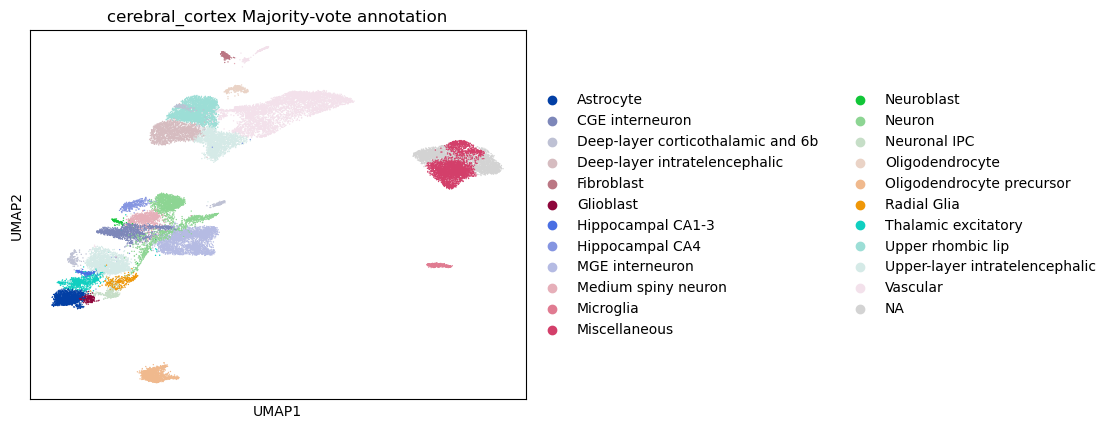

In [60]:
# Plot side by side
sc.pl.umap(
    adata,
    color="predicted_annotation",
    title=f"{region} Majority-vote annotation"
)

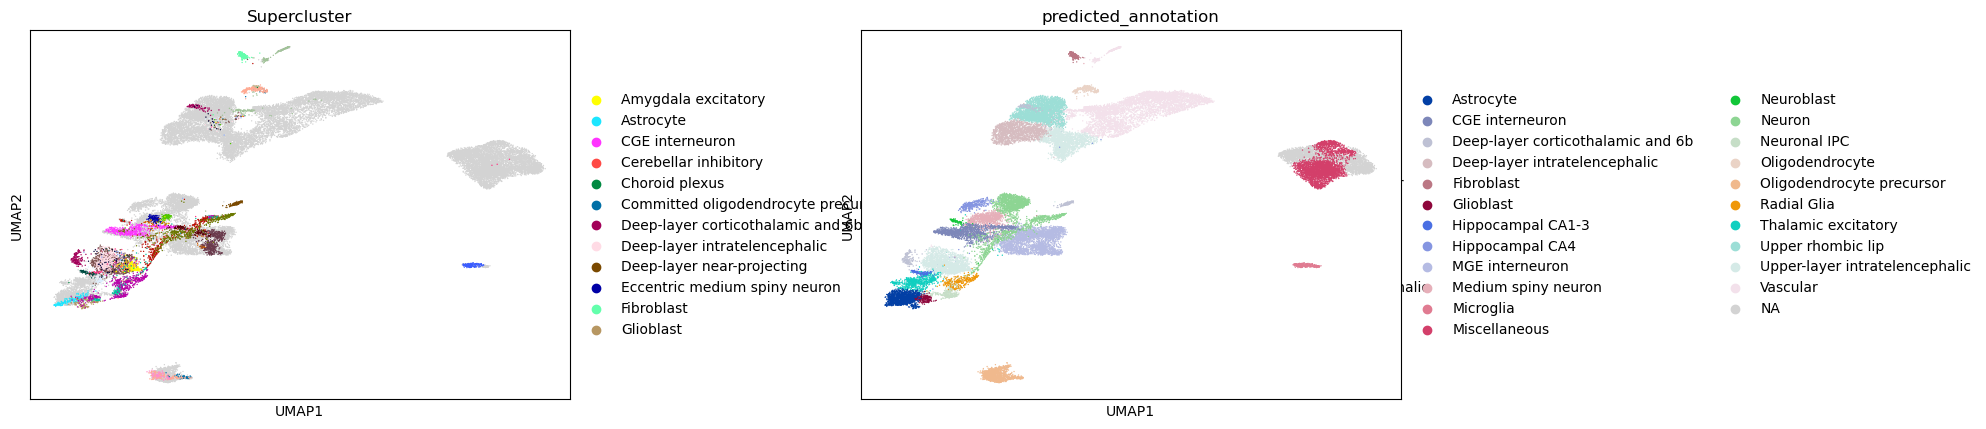

In [61]:
sc.pl.umap(adata, color=['Supercluster', 'predicted_annotation'], wspace=0.4, save=f"_{region}_predicted_ann_{rev_n}.png")

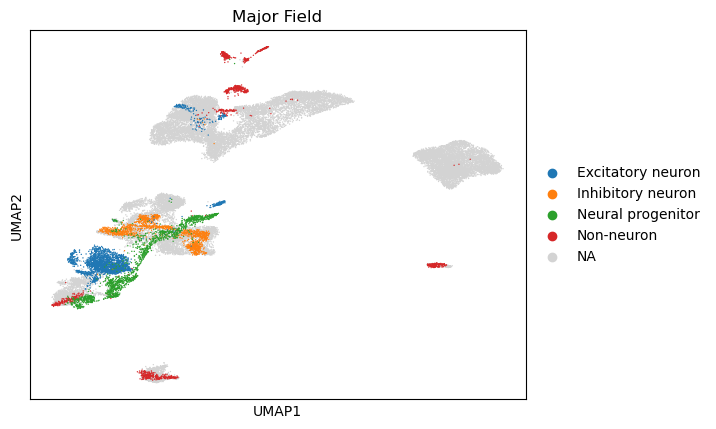

In [62]:
sc.pl.umap(adata, color=['Major Field'], wspace=0.4, save=f"_by celltype_{rev_n}.png")

In [64]:
adata

AnnData object with n_obs × n_vars = 31043 × 19066
    obs: 'species', 'sample_id', 'region', 'donor_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts', 'qc_composite', 'qc_label', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'dataset_source', 'stage', 'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Age', 'CellClass', 'Region', 'Subregion', 'cell_cycle_score', 'total_genes', 'dataset', 'leiden_1.0', 'leiden_2.5', 'predicted_annotation'
    var: 'mt-human_adult', 'ribo-human_adult', 'n_cells_by_counts-human_adult', 'mean_counts-hu

In [65]:
nmr_data = adata[adata.obs['species'] == 'nmr', :].copy()

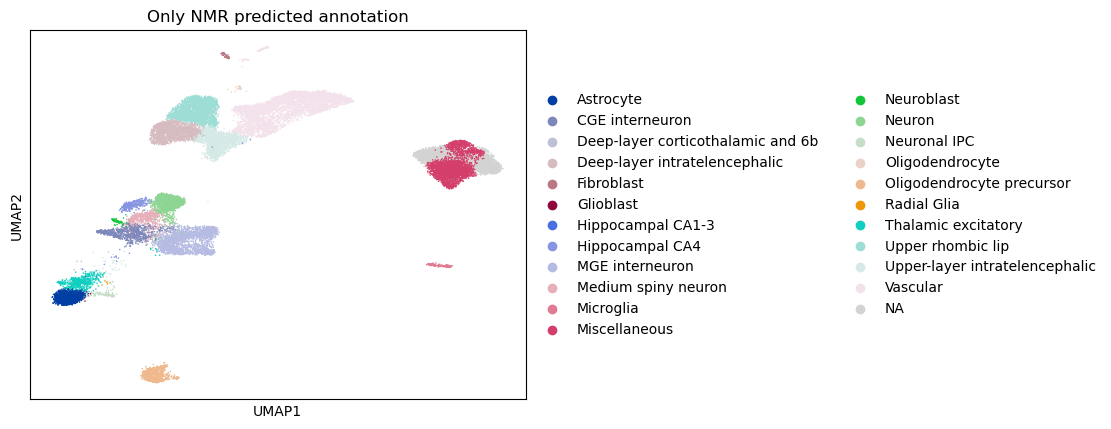

In [66]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    title="Only NMR predicted annotation"
)

In [67]:
nmr_data.X

array([[-0.27614468, -0.19911284, -0.22281887, ..., -0.44460007,
        -1.10237891,  3.18275373],
       [-0.24626581, -0.17756882, -0.19870985, ..., -0.3964943 ,
        -0.98310142, -0.91711577],
       [ 0.10235976,  0.07380603,  0.08259325, ...,  0.16480186,
         0.40862364,  0.38119687],
       ...,
       [ 0.0557815 ,  0.04022099,  0.04500963, ...,  0.08980966,
         0.22268164,  0.20773527],
       [ 0.15163656,  0.10933684,  0.12235429, ...,  0.24413877,
         0.60533826,  0.56470803],
       [ 0.0618188 ,  0.04457416,  0.04988108, ...,  0.09952986,
         0.24678272,  0.2302187 ]], shape=(24378, 19066))

In [71]:
# Rerun pca
sc.pp.pca(nmr_data, svd_solver='arpack',n_comps=40)
sc.pp.neighbors(nmr_data, n_neighbors=40, n_pcs=40)
sc.tl.leiden(nmr_data)
sc.tl.umap(nmr_data, min_dist=0.2)

In [74]:
sc.tl.umap(nmr_data, min_dist=0.6)

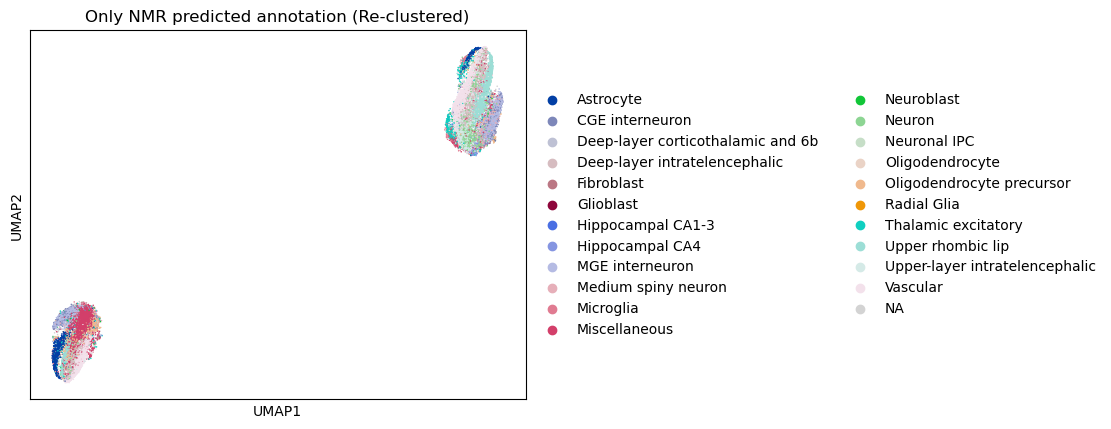

In [75]:
sc.pl.umap(
    nmr_data,
    color="predicted_annotation",
    title="Only NMR predicted annotation (Re-clustered)",
    save=f'{region}_nmr_predicted{rev_n}.png')

In [73]:
nmr_data.obs['predicted_annotation'].value_counts()

predicted_annotation
Vascular                             4149
Miscellaneous                        3130
Upper rhombic lip                    2664
MGE interneuron                      2152
Upper-layer intratelencephalic       1733
Deep-layer intratelencephalic        1645
Neuron                               1231
Astrocyte                            1213
Oligodendrocyte precursor             892
CGE interneuron                       818
Thalamic excitatory                   570
Medium spiny neuron                   561
Hippocampal CA4                       354
Microglia                             172
Neuronal IPC                          101
Neuroblast                             76
Fibroblast                             56
Oligodendrocyte                        20
Radial Glia                             5
Deep-layer corticothalamic and 6b       5
Glioblast                               4
Hippocampal CA1-3                       3
Name: count, dtype: int64

In [85]:
nmr_data

AnnData object with n_obs × n_vars = 24378 × 19066
    obs: 'species', 'sample_id', 'region', 'donor_id', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'total_counts_tf', 'log1p_total_counts_tf', 'pct_counts_tf', 'n_counts', 'qc_composite', 'qc_label', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'dataset_source', 'stage', 'Major Field', 'Supercluster', 'Specific', 'Top Enriched Genes', 'Age', 'CellClass', 'Region', 'Subregion', 'cell_cycle_score', 'total_genes', 'dataset', 'leiden_1.0', 'leiden_2.5', 'predicted_annotation', 'leiden'
    var: 'mt-human_adult', 'ribo-human_adult', 'n_cells_by_counts-human_adult', 'mean

In [87]:
nmr_data.obs[['leiden_2.5', 'predicted_annotation']].to_csv(f'/home/ratopin/NMR-snRNA-seq/scanpy/results/{region}_CrossAnn_predictions{rev_n}.csv', na_rep='Unknown')

In [88]:
cluster_metrics.to_csv(f'/home/ratopin/NMR-snRNA-seq/scanpy/results/{region}_CrossAnn_metrics{rev_n}.csv')

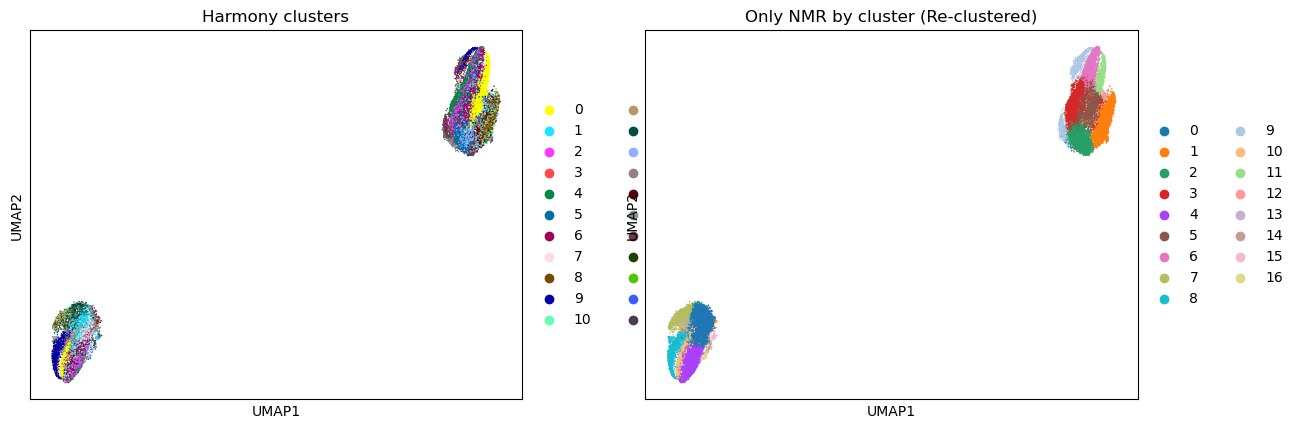

In [76]:
sc.pl.umap(
    nmr_data,
    color=[leiden_res, 'leiden'],
    title=['Harmony clusters' , "Only NMR by cluster (Re-clustered)"],
    save= f'_{region}_nmr_re-clustered{rev_n}.png'
)

In [78]:
# Save object
filename= f'/home/ratopin/big_data/combined/final_{region}_nmr_crossAnn{rev_n}.h5ad'
sc.write(filename, nmr_data)
print(f'Succesfully saved on {filename}')

KeyboardInterrupt: 

In [58]:
nmr_data

AnnData object with n_obs × n_vars = 57171 × 13337
    obs: 'species', 'tissue', 'sample_id', 'replicate', 'sample', 'region', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'Tissue', 'TotalUMIs', 'organism_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'assay_ontology_term_id', 'sex_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'suspension_type', 'dissection', 'total_UMIs', 'cluster_id', 'roi', 'cell_type', 'cell_supertype', 'Age', 'CellClass', 'Chemistry', 'Region', 'Subregion', 'tissue_type', 'tissue_ontology_term_id', 'cell_type_ontology_term_id', 'fraction_mitochondrial', 'fraction_unspliced', 'cell_cycle_score', 'total_genes', 'd

## Marker genes

In [59]:
sc.tl.rank_genes_groups(nmr_data, groupby="leiden_2.5", method="wilcoxon")

/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:435: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:437: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/raquelcr/.conda/envs/scanpy-env/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:440: P

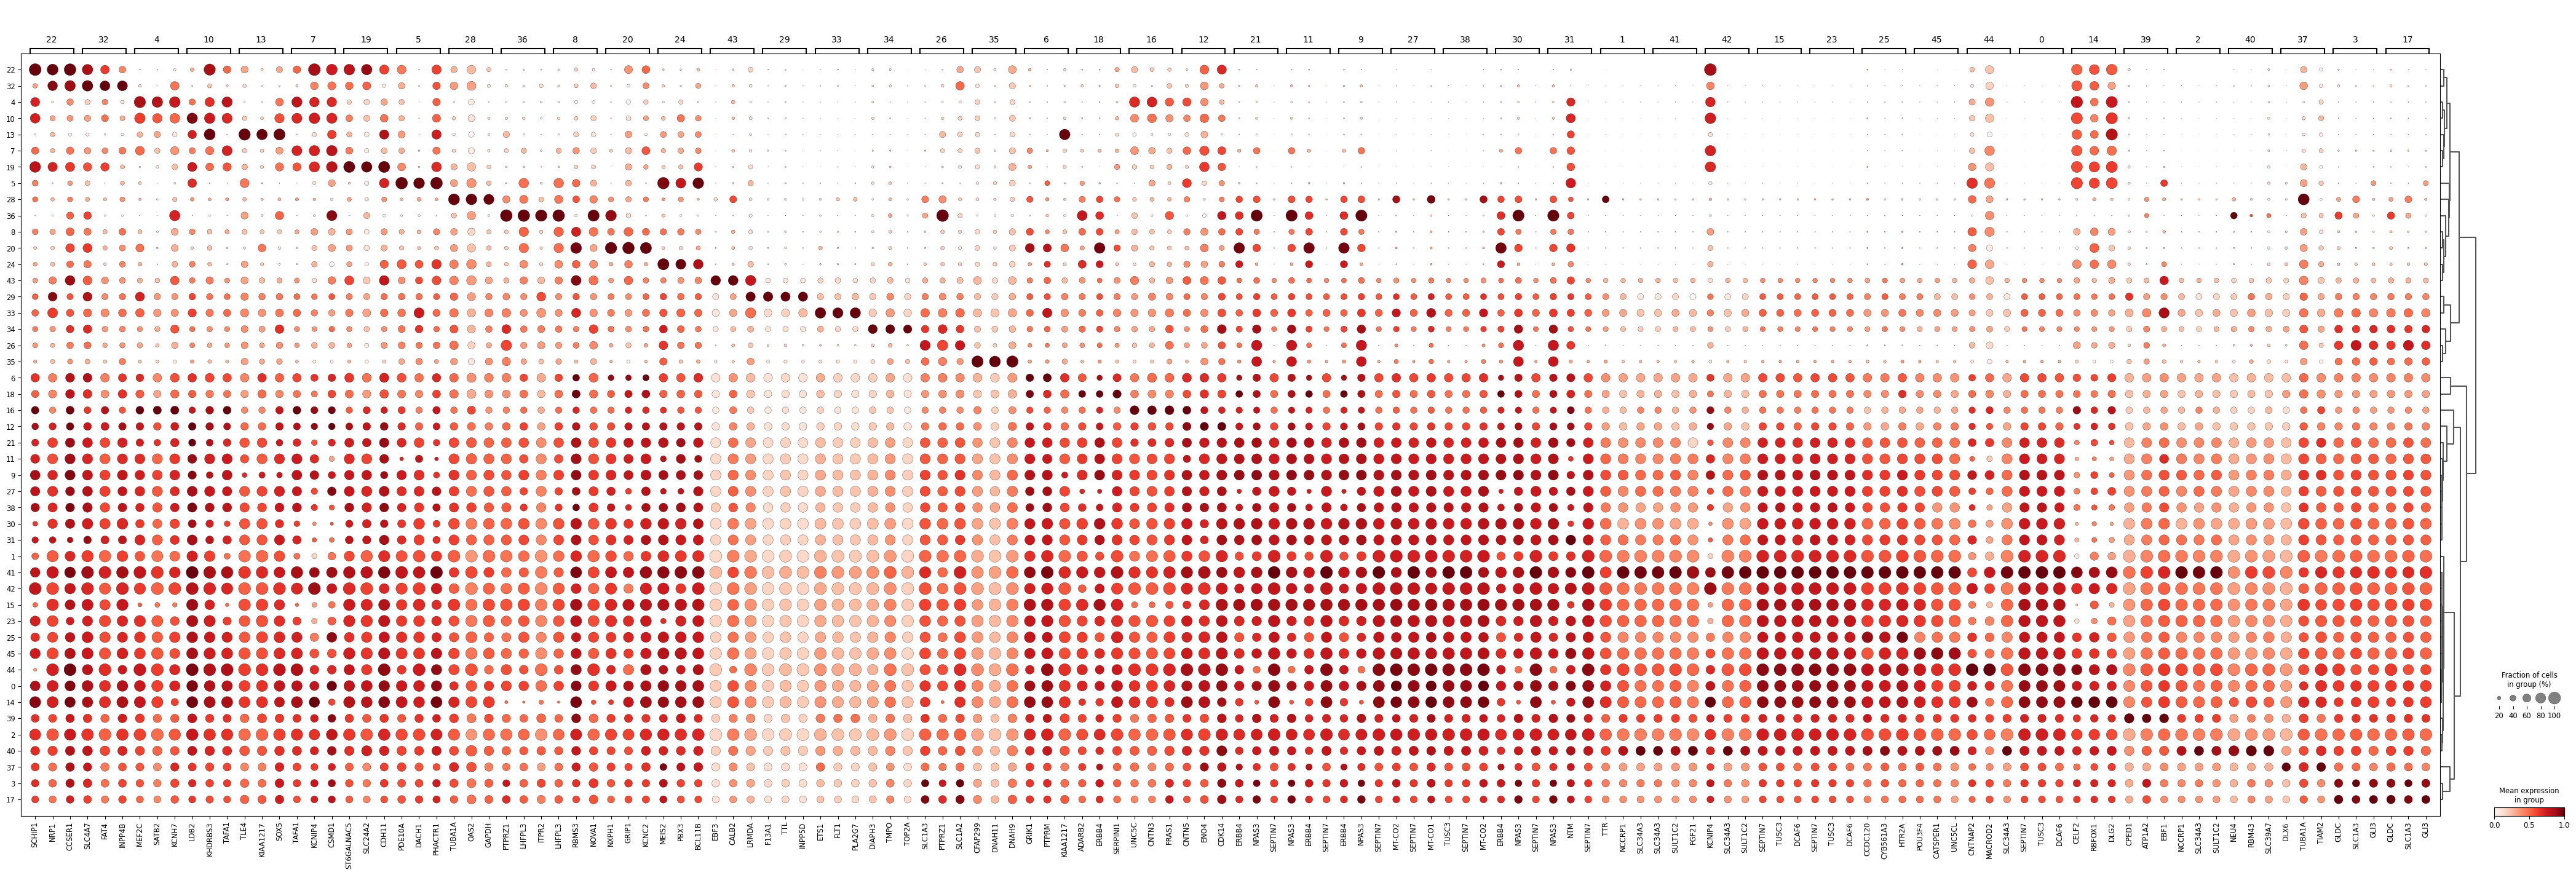

In [82]:
sc.pl.rank_genes_groups_dotplot(nmr_data, groupby="leiden_2.5", standard_scale="var", n_genes=3)

In [80]:
all_markers = pd.DataFrame(columns=['names', 'scores', 'logfoldchanges', 'pvals', 'pvals_adj', 'cluster', 'predicted_annotation'])
for i in nmr_data.obs['leiden_2.5'].cat.categories:
    markers = sc.get.rank_genes_groups_df(nmr_data, group=str(i)).head(20)
    markers['cluster'] = i
    markers['predicted_annotation'] = nmr_data.obs['predicted_annotation'][nmr_data.obs['leiden_2.5'] == i][0]
    all_markers = pd.concat([all_markers, markers], ignore_index=True)

In [81]:
all_markers


names     scores  logfoldchanges         pvals     pvals_adj cluster  \
0     SEPTIN7  62.599613             NaN  0.000000e+00  0.000000e+00       0   
1       TUSC3  62.524048             NaN  0.000000e+00  0.000000e+00       0   
2       DCAF6  62.168804             NaN  0.000000e+00  0.000000e+00       0   
3       PCMT1  62.128586             NaN  0.000000e+00  0.000000e+00       0   
4       OSBP2  62.093204             NaN  0.000000e+00  0.000000e+00       0   
..        ...        ...             ...           ...           ...     ...   
915      AHRR   7.662150        5.821862  1.828456e-14  4.751505e-13      45   
916  SERPINB9   7.660963             NaN  1.845446e-14  4.751505e-13      45   
917    FBXO27   7.660181             NaN  1.856718e-14  4.751505e-13      45   
918     MASP2   7.659798             NaN  1.862252e-14  4.751505e-13      45   
919     GREM2   7.657814             NaN  1.891243e-14  4.751505e-13      45   

    predicted_annotation  
0               Splatter  
1               Splatter  
2               Splatter  
3               Splatter  
4               Splatter  
..                   ...  
915        Miscellaneous  
916        Miscellaneous  
917        Miscellaneous  
918        Miscellaneous  
919        Miscellaneous  

[920 rows x 7 columns]

In [98]:
all_markers

names     scores  logfoldchanges         pvals     pvals_adj cluster  \
0     SEPTIN7  62.599613             NaN  0.000000e+00  0.000000e+00       0   
1       TUSC3  62.524048             NaN  0.000000e+00  0.000000e+00       0   
2       DCAF6  62.168804             NaN  0.000000e+00  0.000000e+00       0   
3       PCMT1  62.128586             NaN  0.000000e+00  0.000000e+00       0   
4       OSBP2  62.093204             NaN  0.000000e+00  0.000000e+00       0   
..        ...        ...             ...           ...           ...     ...   
915      AHRR   7.662150        5.821862  1.828456e-14  4.751505e-13      45   
916  SERPINB9   7.660963             NaN  1.845446e-14  4.751505e-13      45   
917    FBXO27   7.660181             NaN  1.856718e-14  4.751505e-13      45   
918     MASP2   7.659798             NaN  1.862252e-14  4.751505e-13      45   
919     GREM2   7.657814             NaN  1.891243e-14  4.751505e-13      45   

    predicted_annotation  
0               Splatter  
1               Splatter  
2               Splatter  
3               Splatter  
4               Splatter  
..                   ...  
915        Miscellaneous  
916        Miscellaneous  
917        Miscellaneous  
918        Miscellaneous  
919        Miscellaneous  

[920 rows x 7 columns]

In [83]:
all_markers.to_csv(f'/home/raquelcr/scanpy/nmr_cluster_markers{rev_n}.csv', index=False)

In [ ]:
cluster_metrics.dropna(axis=1, how='all', inplace=True)
cluster_metrics.drop(columns=['global_majority_annotation', 'global_majority_frac'], inplace=True)
cluster_metrics['markers']= all_markers.groupby('cluster')['names'].apply(list)
cluster_metrics.drop(columns=['icc_species_fraction'], inplace=True)

In [96]:
cluster_metrics.to_csv(f'/home/raquelcr/scanpy/cluster_specs_{rev_n}.csv')

In [99]:
cluster_metrics

n_cells  pct_not_annotated  shannon_entropy_species  \
cluster                                                        
0           4700           0.831489                 0.654286   
1           4151           0.993014                 0.060074   
2           3743           0.978092                 0.152021   
3           2997           0.906907                 0.446711   
4           2942           1.000000                 0.000000   
5           2934           0.926040                 0.380532   
6           2876           0.956885                 0.256398   
7           2733           0.952799                 0.274385   
8           2206           0.803264                 0.715352   
9           2159           1.000000                 0.000000   
10          1852           0.985961                 0.106512   
11          1795           0.976602                 0.160118   
12          1661           1.000000                 0.000000   
13          1601           1.000000                 0.000000   
14          1450           0.923448                 0.389911   
15          1387           1.000000                 0.000000   
16          1379           1.000000                 0.000000   
17          1312           0.994665                 0.047960   
18          1264           0.934335                 0.349532   
19          1214           0.985173                 0.111315   
20          1195           0.793305                 0.735117   
21          1109           1.000000                 0.000000   
22          1062           0.988701                 0.089289   
23           999           0.992993                 0.060223   
24           964           0.887967                 0.506018   
25           857           0.086348                 0.424160   
26           831           0.998797                 0.013406   
27           810           0.990123                 0.079974   
28           766           1.000000                 0.000000   
29           717           0.757322                 0.799465   
30           712           1.000000                 0.000000   
31           671           1.000000                 0.000000   
32           613           0.942904                 0.315809   
33           544           0.795956                 0.729943   
34           542           0.907749                 0.443939   
35           505           0.645545                 0.937984   
36           481           1.000000                 0.000000   
37           431           0.962877                 0.228942   
38           404           1.000000                 0.000000   
39           360           0.497222                 0.999978   
40           312           0.423077                 0.982859   
41           297           0.111111                 0.503258   
42           278           0.050360                 0.287923   
43           262           0.893130                 0.490403   
44           147           0.040816                 0.246023   
45           132           0.818182                 0.684038   

             human_majority_annotation  human_majority_frac  \
cluster                                                       
0                             Splatter             0.410354   
1                Cerebellar inhibitory             0.724138   
2                             Splatter             0.280488   
3                            Astrocyte             0.813620   
4                                  NaN                  NaN   
5                  Medium spiny neuron             0.677419   
6                      MGE interneuron             0.669355   
7                  Amygdala excitatory             0.434109   
8                             Splatter             0.555300   
9                                  NaN                  NaN   
10       Deep-layer intratelencephalic             0.269231   
11                 Medium spiny neuron             0.976190   
12                                 NaN                

In [97]:
# dataframe from barcodes to clusters
nmr_data.obs[['sample','tissue', 'replicate', 'leiden_2.5', 'predicted_annotation' ]].to_csv(f'/home/raquelcr/scanpy/nmr_barcodes_to_clusters_{rev_n}.csv')

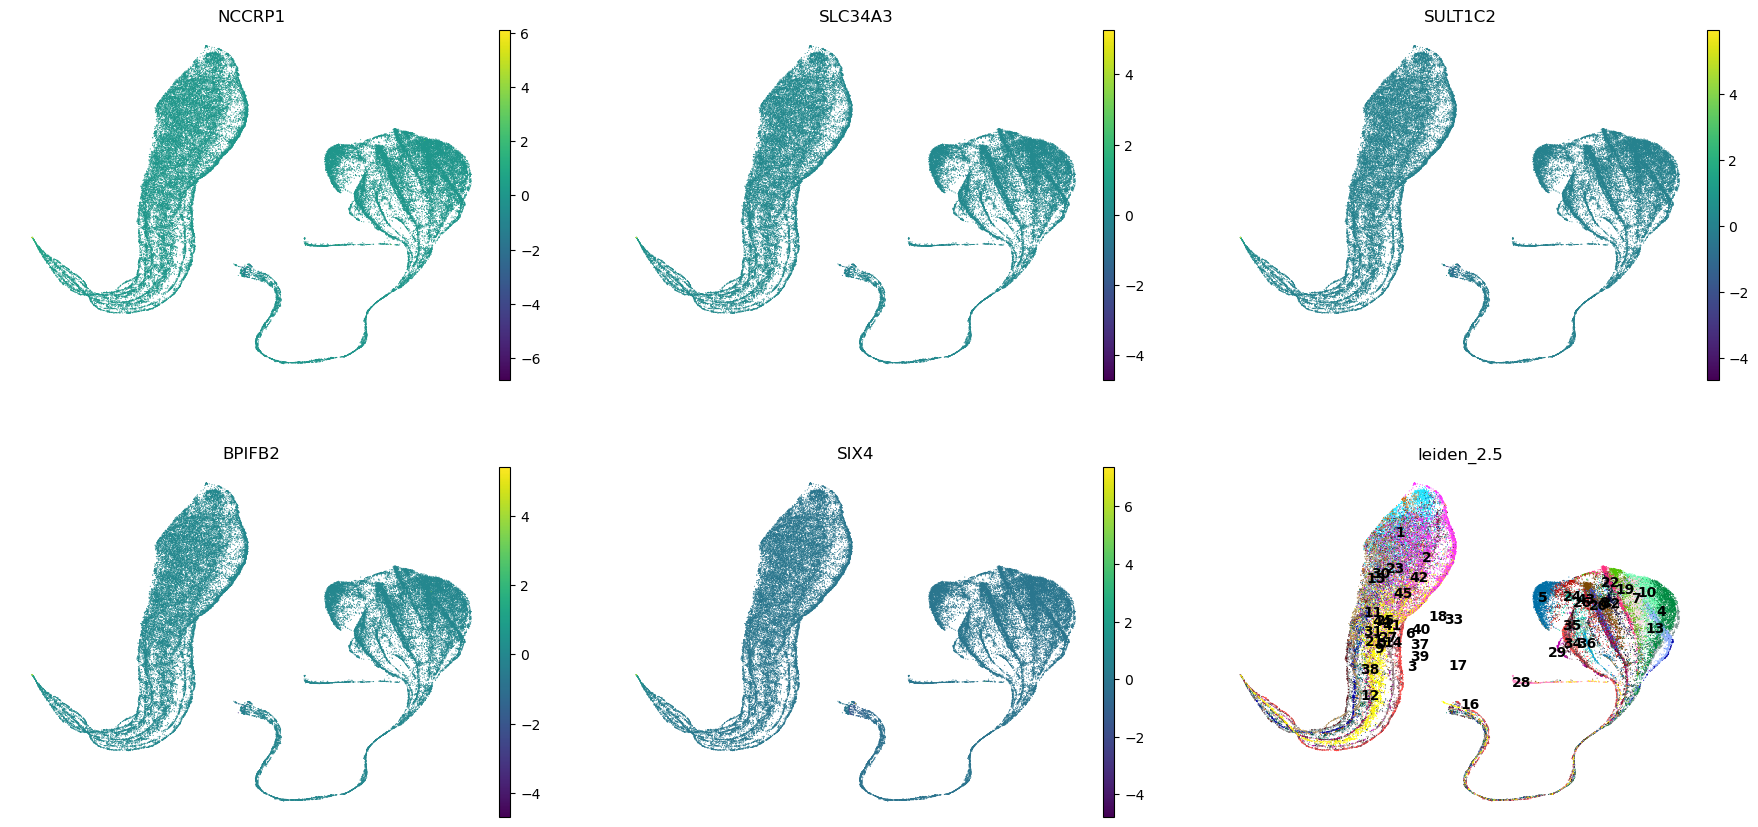

In [64]:
dc_cluster_genes = sc.get.rank_genes_groups_df(nmr_data, group="2").head(5)["names"]
sc.pl.umap(
    nmr_data,
    color=[*dc_cluster_genes, "leiden_2.5"],
    legend_loc="on data",
    frameon=False,
    ncols=3,
)